[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ELTE-DSED/Intro-Data-Security/blob/main/module_03_data_poisoning/Lab_3a_Data_Poisoning_Label_Flipping.ipynb)

# **Lab 3a: Data Poisoning Attacks (Label Flipping & Sample Injection)**

**Course:** Introduction to Data Security Pr.  
**Module 3:** Integrity Attacks - Data Poisoning  
**Estimated Time:** 45 minutes

---

<div align="center">
  <img src="images/label_flipping.png">
</div>

## **Learning Objectives**

By the end of this lab, you will be able to:

1. **Implement** label-flipping poisoning attacks
2. **Craft** targeted poison samples
3. **Measure** poison success via misclassification rates
4. **Analyze** impact vs. poison budget
5. **Design** defenses against poisoning

## **Table of Contents**

1. [Setup & Imports](#setup)
2. [Label-Flip Poisoning](#label-flip)
3. [Targeted Poisoning](#targeted)
4. [Poison Budget Analysis](#budget)
5. [Detection & Defense](#defense)
6. [Exercises](#exercises)

## **Setup & Imports** <a name="setup"></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## **Label-Flip Poisoning** <a name="label-flip"></a>

In label-flip poisoning, the attacker flips the labels of a subset of training samples.

**Goal:** Degrade model accuracy or create specific misclassifications.

In [2]:
# Load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transform, download=True
)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


In [9]:
def create_label_flip_poison(dataset, flip_fraction=0.1, target_class=None):
    """
    Create poisoned dataset by flipping labels.
    
    Args:
        dataset: original dataset
        flip_fraction: fraction of samples to flip (0.0-1.0)
        target_class: if None, flip random labels; else flip to target_class
    """
    # Copy dataset
    poisoned_data = [(x, y) for x, y in dataset]
    
    # Select indices to poison
    n_poison = int(len(poisoned_data) * flip_fraction)
    poison_indices = np.random.choice(len(poisoned_data), n_poison, replace=False)
    
    poison_count = 0
    for idx in poison_indices:
        x, y = poisoned_data[idx]
        if target_class is not None:
            new_label = target_class
        else:
            # Random wrong label
            new_label = np.random.randint(0, 10)
            while new_label == y:
                new_label = np.random.randint(0, 10)
        
        poisoned_data[idx] = (x, new_label)
        poison_count += 1
    
    return poisoned_data, poison_indices, poison_count

# Create poisoned dataset with 10% label flip
poisoned_train, poison_idx, poison_count = create_label_flip_poison(
    train_dataset, flip_fraction=0.1, target_class=None
)

print(f"Poisoned {poison_count} samples (10% of training data)")

Poisoned 6000 samples (10% of training data)


## **Targeted Poisoning** <a name="targeted"></a>

Target-class flipping: flip all '3' samples to become '8'.

In [8]:
def create_targeted_poison(dataset, source_class=3, target_class=8, flip_fraction=0.5):
    """
    Create targeted poisoning: flip source_class → target_class.
    """
    poisoned_data = [(x, y) for x, y in dataset]
    
    # Find all samples of source class
    source_indices = [i for i, (_, y) in enumerate(poisoned_data) if y == source_class]
    
    # Poison a fraction of them
    n_poison = int(len(source_indices) * flip_fraction)
    poison_indices = np.random.choice(source_indices, n_poison, replace=False)
    
    for idx in poison_indices:
        x, _ = poisoned_data[idx]
        poisoned_data[idx] = (x, target_class)
    
    return poisoned_data, poison_indices

# Create targeted poison: 3 → 8
poisoned_train_targeted, poison_idx_targeted = create_targeted_poison(
    train_dataset, source_class=3, target_class=8, flip_fraction=0.5
)

print(f"Poisoned {len(poison_idx_targeted)} samples of class 3 to class 8")

Poisoned 3065 samples of class 3 to class 8


## **Poison Budget Analysis** <a name="budget"></a>

How does poison effectiveness scale with the fraction of poisoned data?

**Note (fast mode):** This loop can be slow on full MNIST. We limit training to a subset and cap batches per epoch for quick experimentation.

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Quick training function
def train_epoch(model, loader, optimizer, device, max_batches=None):
    model.train()
    criterion = nn.CrossEntropyLoss()
    for batch_idx, (x, y) in enumerate(loader):
        if max_batches is not None and batch_idx >= max_batches:
            break
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()

def evaluate(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

print("Training utility functions defined.")

Training utility functions defined.


In [11]:
# Analyze poison effectiveness vs. budget
poison_fractions = [0.0, 0.05, 0.1, 0.2]
results = {'poison_fraction': [], 'clean_accuracy': []}

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Fast-mode settings
max_train_samples = 8000
max_batches = 80

def make_subset(data, n):
    n = min(n, len(data))
    indices = np.random.choice(len(data), n, replace=False)
    if isinstance(data, list):
        return [data[i] for i in indices]
    return Subset(data, indices)

for frac in poison_fractions:
    print(f"\nTraining with poison fraction: {frac}")
    # Reset seeds per iteration
    torch.manual_seed(42)
    np.random.seed(42)
    # --- 
    
    # Create poisoned data
    if frac == 0:
        train_data = train_dataset
    else:
        train_data, _, _ = create_label_flip_poison(train_dataset, flip_fraction=frac)
    
    # Subsample for speed
    train_data = make_subset(train_data, max_train_samples)
    
    # Train model
    model = SimpleCNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
    
    for epoch in range(3):  # Quick 3 epochs
        train_epoch(model, train_loader, optimizer, device, max_batches=max_batches)
    
    acc = evaluate(model, test_loader, device)
    results['poison_fraction'].append(frac)
    results['clean_accuracy'].append(acc)
    print(f"Test accuracy: {acc * 100:.2f}%")

results_df = pd.DataFrame(results)
print("\n" + "="*50)
print(results_df.to_string(index=False))


Training with poison fraction: 0.0
Test accuracy: 97.18%

Training with poison fraction: 0.05
Test accuracy: 96.92%

Training with poison fraction: 0.1
Test accuracy: 96.60%

Training with poison fraction: 0.2
Test accuracy: 96.33%

 poison_fraction  clean_accuracy
            0.00          0.9718
            0.05          0.9692
            0.10          0.9660
            0.20          0.9633


### **Visualize Poison Impact**

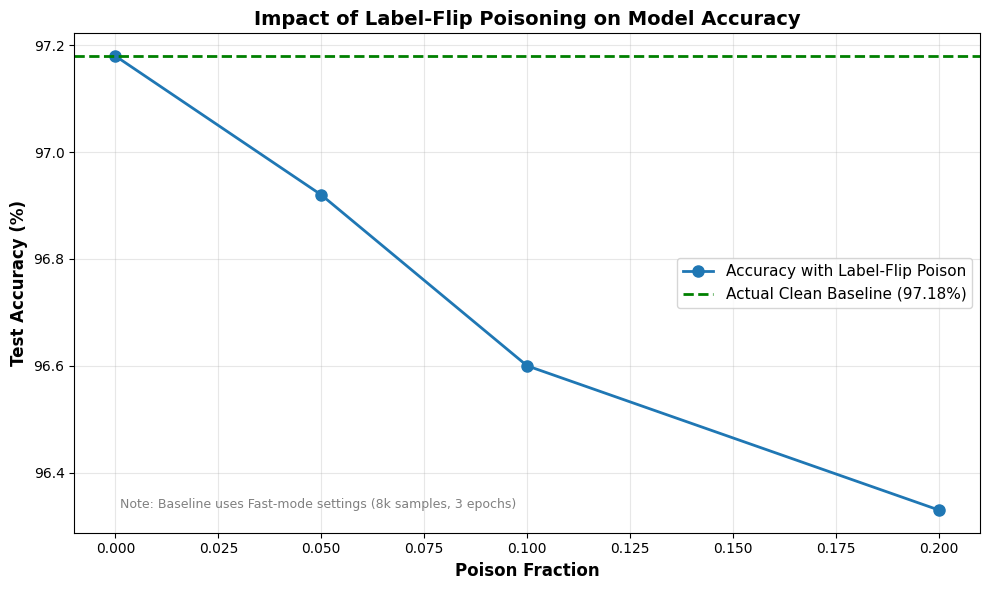

In [12]:
# Plot poison effectiveness
plt.figure(figsize=(10, 6))
plt.plot(results['poison_fraction'], [acc * 100 for acc in results['clean_accuracy']], 
         marker='o', linewidth=2, markersize=8, label='Accuracy with Label-Flip Poison')
clean_baseline = results['clean_accuracy'][0] * 100
plt.axhline(y=clean_baseline, color='green', linestyle='--', linewidth=2, label=f'Actual Clean Baseline ({clean_baseline:.2f}%)')
plt.xlabel('Poison Fraction', fontsize=12, fontweight='bold')
plt.ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Impact of Label-Flip Poisoning on Model Accuracy', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.annotate('Note: Baseline uses Fast-mode settings (8k samples, 3 epochs)', 
             xy=(0.05, 0.05), xycoords='axes fraction', fontsize=9, color='gray')
plt.show()

## **Detection & Defense** <a name="defense"></a>

### **Strategy 1: Outlier Detection (Isolation Forest)**

In [13]:
from sklearn.ensemble import IsolationForest

def detect_poison_outliers(dataset, contamination=0.1):
    """
    Use Isolation Forest to detect anomalous (potentially poisoned) samples.
    """
    # Flatten images
    X = np.array([x.numpy().flatten() for x, _ in dataset])
    
    # Fit Isolation Forest
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    predictions = iso_forest.fit_predict(X)
    
    # -1 = anomaly, 1 = normal
    anomaly_indices = np.where(predictions == -1)[0]
    
    return anomaly_indices, iso_forest

# Detect poison in poisoned dataset
anomaly_idx, iso_forest = detect_poison_outliers(
    [(x, y) for x, y in poisoned_train], contamination=0.1
)

print(f"Detected {len(anomaly_idx)} anomalies (expected ~6000 for 10% poison)")

Detected 6000 anomalies (expected ~6000 for 10% poison)


### **Strategy 2: Confident Learning (Label Cleaning)**

In [14]:
def suspicious_labels(model, dataset, device, threshold=0.5):
    """
    Identify samples where model prediction disagrees with label.
    High disagreement suggests label corruption.
    """
    model.eval()
    suspicious = []
    
    with torch.no_grad():
        for idx, (x, y) in enumerate(dataset[:1000]):  # Check first 1000
            x_tensor = x.unsqueeze(0).to(device)
            logits = model(x_tensor)
            probs = torch.softmax(logits, dim=1)
            pred_prob = probs[0, y].item()
            
            # Low confidence in true label = suspicious
            if pred_prob < threshold:
                suspicious.append((idx, y, pred_prob))
    
    return suspicious

print("Label cleaning function defined.")

Label cleaning function defined.


In [15]:
# Use the trained model to find suspicious labels in the poisoned dataset
# Note: model should be the one trained in the budget loop
suspicious_samples = suspicious_labels(model, poisoned_train, device, threshold=0.3)

print(f"Identified {len(suspicious_samples)} suspicious samples in the first 1000 samples of poisoned_train.")
if suspicious_samples:
    print("\nExamples of suspected poison (Index, Label, Confidence):")
    for s in suspicious_samples[:5]:
        print(s)

Identified 151 suspicious samples in the first 1000 samples of poisoned_train.

Examples of suspected poison (Index, Label, Confidence):
(9, 0, 0.01852145604789257)
(22, 5, 0.012656725011765957)
(25, 4, 0.009845863096415997)
(39, 4, 0.054507091641426086)
(48, 9, 0.04201969876885414)


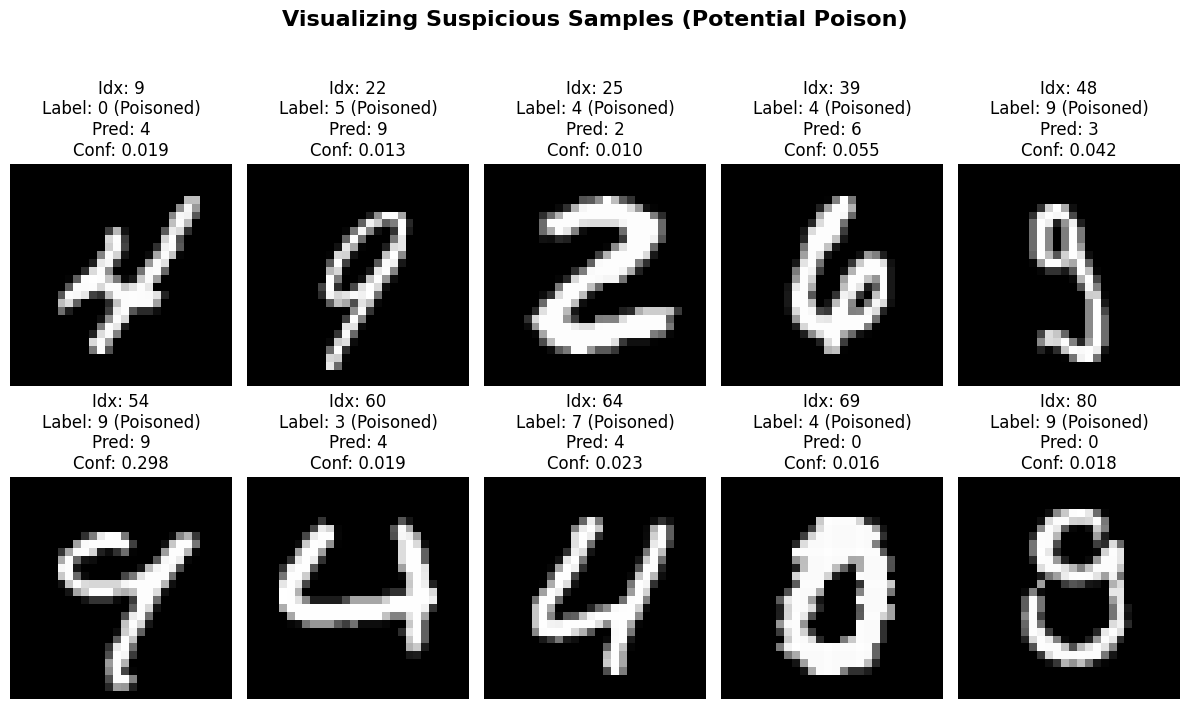

In [16]:
# Visualize the first few suspicious samples
if suspicious_samples:
    plt.figure(figsize=(12, 8))
    for i, (idx, label, conf) in enumerate(suspicious_samples[:10]):
        img, _ = poisoned_train[idx]
        
        # Get model prediction
        logits = model(img.unsqueeze(0).to(device))
        pred = logits.argmax(dim=1).item()
        
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"Idx: {idx}\nLabel: {label} (Poisoned)\nPred: {pred}\nConf: {conf:.3f}")
        plt.axis('off')
    
    plt.suptitle("Visualizing Suspicious Samples (Potential Poison)", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("No suspicious samples found to visualize.")

## **Exercises** <a name="exercises"></a>

1. **Vary poison fractions:** Test with 1%, 5%, 15%, 25% and plot the accuracy curve.
2. **Compare targeted vs. random:** Which is more effective? Why?
3. **Defense evaluation:** Which detection method (Isolation Forest vs. Confident Learning) works better?
4. **Poisoning different classes:** Does poisoning class "3" vs. class "0" have different effects?
5. **Data cleaning:** Implement a defense that removes suspected poison and retrains.

## **References**

1. Li, Y., Jiang, Y., Li, Z., & Xia, S. T. (2020). **Backdoor Learning: A Survey**. arXiv preprint [arXiv:2007.08745](https://arxiv.org/abs/2007.08745).